# Model evaluation

In [1]:
############### CHANGE THESE TO YOUR LIKING ###############

specie = 'leptocybe-invasa' # 'leptocybe-invasa' # 'thaumastocoris-peregrinus' # 
pseudoabsence = 'random' # 'biased-land-cover' # 'biased' # 'random' # 
training = 'east-asia' #'east-asia'
interest = 'south-east-asia'
savefig = False

###########################################################

In [2]:
import os

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import elapid as ela

from shapely import wkt
from elapid import utils
from sklearn import metrics, inspection

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [3]:
def subplot_layout(nplots):

    ncols = min(int(np.ceil(np.sqrt(nplots))), 4)
    nrows = int(np.ceil(nplots / ncols))
    
    return ncols, nrows

In [4]:
docs_path = os.path.join(os.path.dirname(os.getcwd()), 'docs')
out_path = os.path.join(os.path.dirname(os.getcwd()), 'out', specie)
output_path = os.path.join(out_path, 'output')

## 1. Training model performance

In [5]:
# https://support.ecocommons.org.au/support/solutions/articles/6000256107-interpretation-of-sdm-model-outputs
# https://towardsdatascience.com/receiver-operating-characteristic-curves-demystified-in-python-bd531a4364d0
# https://www.aporia.com/learn/ultimate-guide-to-precision-recall-auc-understanding-calculating-using-pr-auc-in-ml/
# https://deepchecks.com/f1-score-accuracy-roc-auc-and-pr-auc-metrics-for-models/
# https://pro.arcgis.com/en/pro-app/latest/tool-reference/spatial-statistics/how-presence-only-prediction-works.htm
# https://www.esri.com/arcgis-blog/products/arcgis-pro/analytics/presence-only-prediction-maxent-101-using-gis-to-model-species-distribution/

In [6]:
experiment_name = 'exp_%s_%s_%s' %(pseudoabsence, training, interest)
exp_path = os.path.join(output_path, experiment_name)

train_input_data_name = 'model-train_input-data_%s_%s_%s.csv' %(specie, pseudoabsence, training)
run_name = 'model-train_%s_%s_%s.ela' %(specie, pseudoabsence, training)
nc_name = 'model-train_%s_%s_%s.nc' %(specie, pseudoabsence, training)

In [7]:
# load training data
df = pd.read_csv(os.path.join(exp_path, train_input_data_name), index_col=0)
df['geometry'] = df['geometry'].apply(wkt.loads)
train = gpd.GeoDataFrame(df, crs='EPSG:4326')

# split the x/y data
x_train = train.drop(columns=['class', 'geometry'])
y_train = train['class']

# load training model
model_train = utils.load_object(os.path.join(exp_path, run_name))

y_train_predict = model_train.predict(x_train)

In [8]:
# model training performance

# ROC-curve
fpr_train, tpr_train, thresholds = metrics.roc_curve(y_train, y_train_predict)
auc_train = metrics.roc_auc_score(y_train, y_train_predict)

# PR-curve
precision_train, recall_train, _= metrics.precision_recall_curve(y_train, y_train_predict) 
pr_auc_train = metrics.auc(recall_train, precision_train)

print(f"Training ROC-AUC score: {auc_train:0.3f}")
print(f"PR-AUC Score: {pr_auc_train:0.3f}")

Training ROC-AUC score: 0.943
PR-AUC Score: 0.127


|  |  | Specie existance |  |
| ------ | :-------: | :------: | :-------: |
| |  | **+** | **--** |
| **Specie observed** | **+** | True Positive (TP) | False Positive (FP) |
| | **--** | False Negative (FN) | True Negative (TN) |
| | | **All existing species (TP + FN)** | **All non-existing species (FP + TN)** |


$$TPR = \frac{TP}{TP + FN}$$
$$FPR = \frac{FP}{FP + TN}$$

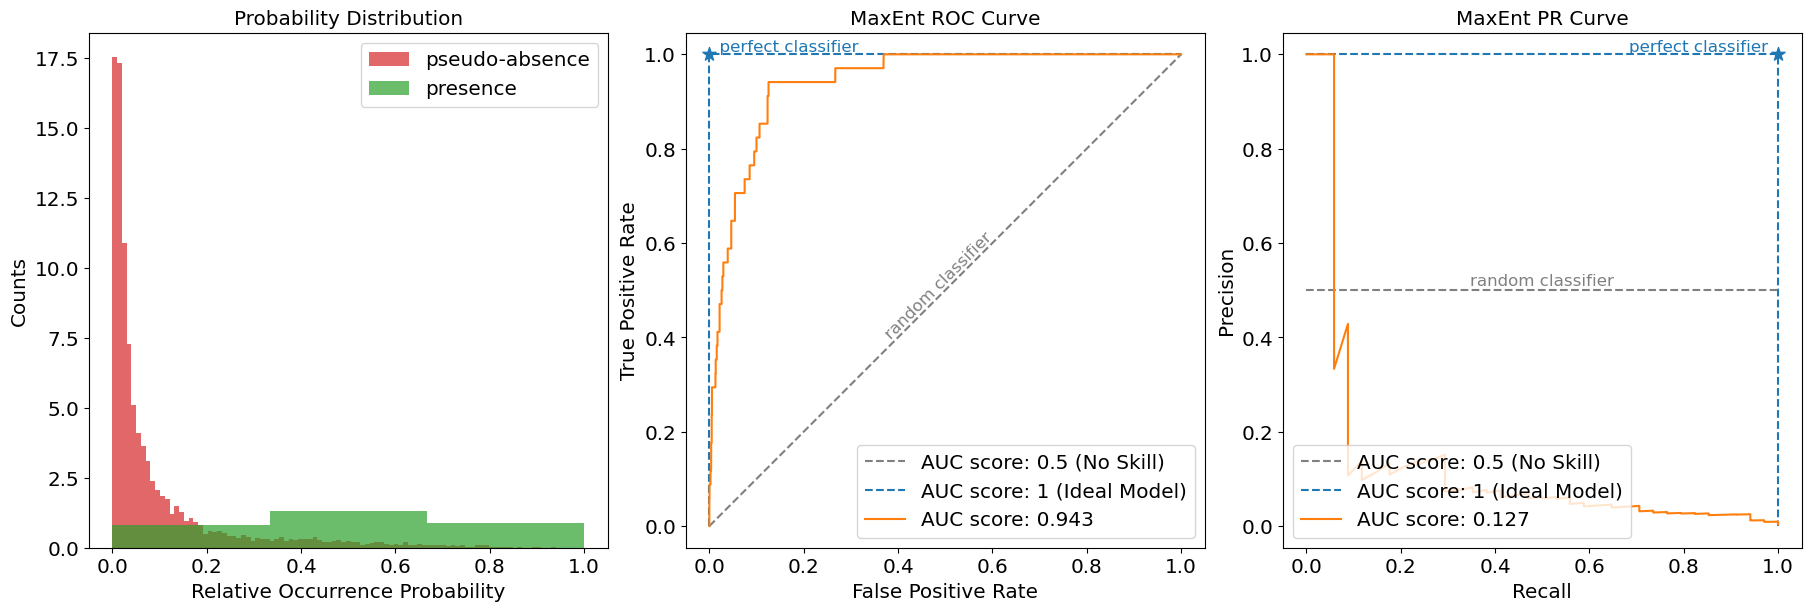

In [9]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6),constrained_layout=True)

# 
ax[0].hist(y_train_predict[y_train==0], bins=np.linspace(0,1,int((y_train==0).sum()/100 + 1)), density=True, color='tab:red', alpha=0.7, label='pseudo-absence')
ax[0].hist(y_train_predict[y_train==1], bins=np.linspace(0,1,int((y_train==1).sum()/10+1)), density=True, color='tab:green', alpha=0.7, label='presence')

ax[0].set_xlabel('Relative Occurrence Probability')
ax[0].set_ylabel('Counts')
ax[0].set_title('Probability Distribution')

ax[0].legend(loc='upper right')

ax[1].plot([0, 1], [0, 1], '--', label=f'AUC score: 0.5 (No Skill)', color='gray')
ax[1].text(0.4, 0.4, 'random classifier', fontsize=12, color='gray',
           rotation=45, rotation_mode='anchor', horizontalalignment='left',
           verticalalignment='bottom',transform=ax[1].transAxes)

ax[1].plot([0, 0, 1], [0, 1, 1], '--', label=f'AUC score: 1 (Ideal Model)', color='tab:blue', zorder=-1)
ax[1].text(0, 1, '  perfect classifier', fontsize=12, color='tab:blue', 
           horizontalalignment='left', verticalalignment='bottom')
ax[1].scatter(0, 1, marker='*', s=100, color='tab:blue')

ax[1].plot(fpr_train, tpr_train, label=f'AUC score: {auc_train:0.3f}', color='tab:orange')
ax[1].axis('equal')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('MaxEnt ROC Curve')
ax[1].legend(loc='lower right')

## 
ax[2].plot([0, 1], [0.5, 0.5], '--', color='gray', label=f'AUC score: 0.5 (No Skill)')
ax[2].text(0.5, 0.52, 'random classifier', fontsize=12, color='gray',
           horizontalalignment='center', verticalalignment='center')
ax[2].plot([0, 1, 1], [1, 1, 0], '--', label=f'AUC score: 1 (Ideal Model)', color='tab:blue', zorder=-1)
ax[2].text(1, 1, 'perfect classifier  ', fontsize=12, color='tab:blue', 
           horizontalalignment='right', verticalalignment='bottom')
ax[2].scatter(1, 1, marker='*', s=100, color='tab:blue')


ax[2].plot(recall_train, precision_train, label=f'AUC score: {pr_auc_train:0.3f}', color='tab:orange')
ax[2].axis('equal')
ax[2].set_xlabel('Recall')
ax[2].set_ylabel('Precision')
ax[2].set_title('MaxEnt PR Curve')
ax[2].legend(loc='lower left')

In [10]:
if savefig:
    fig.savefig(os.path.join(figs_path, '06_roc-pr-auc_%s_%s.png' %(specie, training)), transparent=True, bbox_inches='tight')

## 2. Test model performance

In [11]:
test_input_data_name = 'model-test_input-data_%s_%s_%s.csv' %(specie, pseudoabsence, interest)

In [12]:
# load test data
df = pd.read_csv(os.path.join(exp_path, test_input_data_name), index_col=0)
df['geometry'] = df['geometry'].apply(wkt.loads)
test = gpd.GeoDataFrame(df, crs='EPSG:4326')

In [13]:
# split the x/y data
x_test = test.drop(columns=['class', 'geometry'])
y_test = test['class']

# predict the model for the test data
y_test_predict = model_train.predict(x_test)

In [14]:
# ROC-curve
fpr_test, tpr_test, _ = metrics.roc_curve(y_test, y_test_predict)
auc_test = metrics.roc_auc_score(y_test, y_test_predict)

# PR-curve
precision_test, recall_test, _= metrics.precision_recall_curve(y_test, y_test_predict) 
pr_auc_test = metrics.auc(recall_test, precision_test)

print(f"Training ROC-AUC score: {auc_train:0.3f}")
print(f"Test ROC-AUC score: {auc_test:0.3f}")

print(f"Training PR-AUC Score: {pr_auc_train:0.3f}")
print(f"Test PR-AUC Score: {pr_auc_test:0.3f}")

Training ROC-AUC score: 0.943
Test ROC-AUC score: 0.529
Training PR-AUC Score: 0.127
Test PR-AUC Score: 0.001


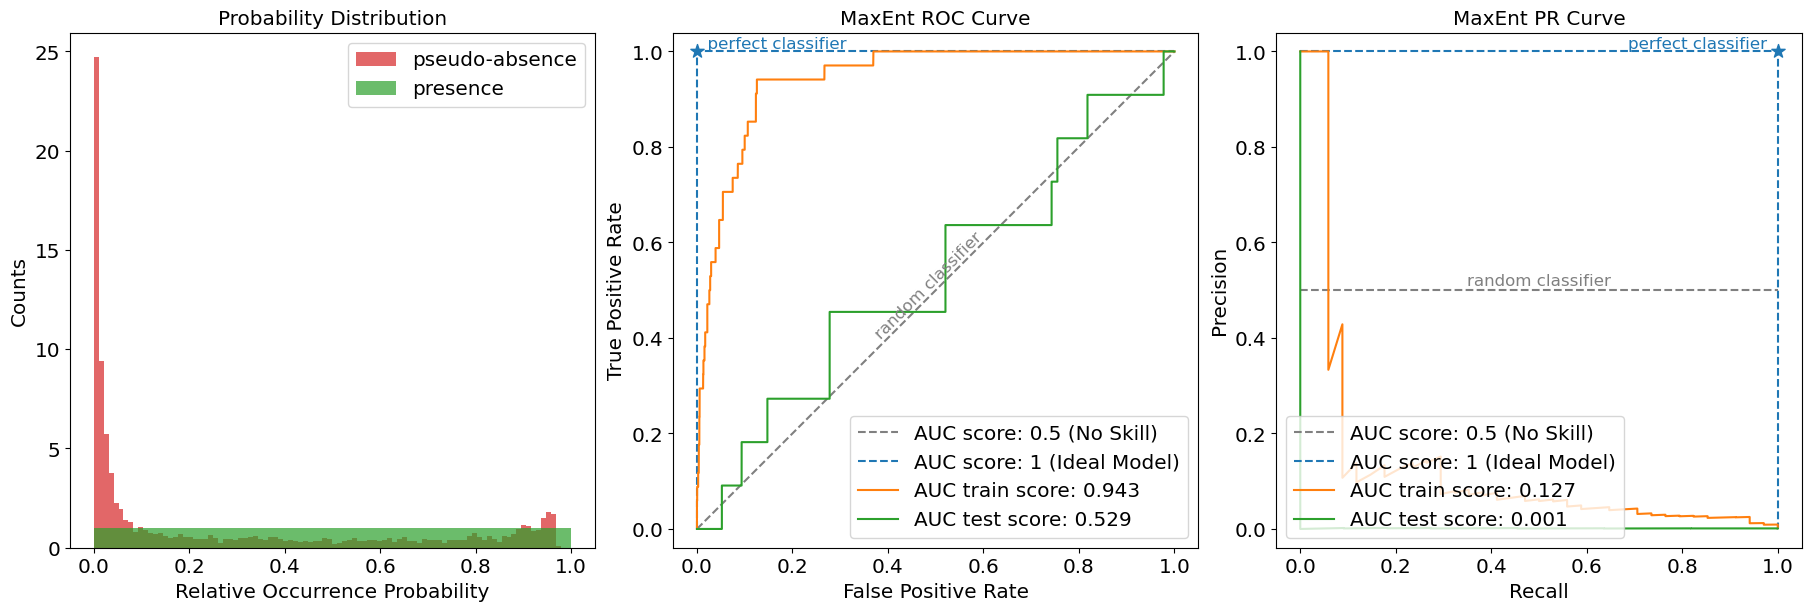

In [15]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6),constrained_layout=True)

# 
ax[0].hist(y_test_predict[y_test==0], bins=np.linspace(0,1,int((y_test==0).sum()/100 + 1)), density=True, color='tab:red', alpha=0.7, label='pseudo-absence')
ax[0].hist(y_test_predict[y_test==1], bins=np.linspace(0,1,int((y_test==1).sum()/10+1)), density=True, color='tab:green', alpha=0.7, label='presence')

ax[0].set_xlabel('Relative Occurrence Probability')
ax[0].set_ylabel('Counts')
ax[0].set_title('Probability Distribution')

ax[0].legend(loc='upper right')

ax[1].plot([0, 1], [0, 1], '--', label=f'AUC score: 0.5 (No Skill)', color='gray')
ax[1].text(0.4, 0.4, 'random classifier', fontsize=12, color='gray',
           rotation=45, rotation_mode='anchor', horizontalalignment='left',
           verticalalignment='bottom',transform=ax[1].transAxes)

ax[1].plot([0, 0, 1], [0, 1, 1], '--', label=f'AUC score: 1 (Ideal Model)', color='tab:blue', zorder=-1)
ax[1].text(0, 1, '  perfect classifier', fontsize=12, color='tab:blue', 
           horizontalalignment='left', verticalalignment='bottom')
ax[1].scatter(0, 1, marker='*', s=100, color='tab:blue')

ax[1].plot(fpr_train, tpr_train, label=f'AUC train score: {auc_train:0.3f}', color='tab:orange')
ax[1].plot(fpr_test, tpr_test, label=f'AUC test score: {auc_test:0.3f}', color='tab:green')

ax[1].axis('equal')
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('MaxEnt ROC Curve')
ax[1].legend(loc='lower right')

## 
ax[2].plot([0, 1], [0.5, 0.5], '--', color='gray', label=f'AUC score: 0.5 (No Skill)')
ax[2].text(0.5, 0.52, 'random classifier', fontsize=12, color='gray',
           horizontalalignment='center', verticalalignment='center')
ax[2].plot([0, 1, 1], [1, 1, 0], '--', label=f'AUC score: 1 (Ideal Model)', color='tab:blue', zorder=-1)
ax[2].text(1, 1, 'perfect classifier  ', fontsize=12, color='tab:blue', 
           horizontalalignment='right', verticalalignment='bottom')
ax[2].scatter(1, 1, marker='*', s=100, color='tab:blue')


ax[2].plot(recall_train, precision_train, label=f'AUC train score: {pr_auc_train:0.3f}', color='tab:orange')
ax[2].plot(recall_test, precision_test, label=f'AUC test score: {pr_auc_test:0.3f}', color='tab:green')

ax[2].axis('equal')
ax[2].set_xlabel('Recall')
ax[2].set_ylabel('Precision')
ax[2].set_title('MaxEnt PR Curve')
ax[2].legend(loc='lower left')

In [16]:
if savefig:
    fig.savefig(os.path.join(figs_path, '06_roc-pr-auc_%s_%s.png' %(specie, interest)), transparent=True, bbox_inches='tight')

## 3. Evaluate model

### 3.2 Partial dependence plot/ Response curves

In [17]:
# fig, ax = model_train.partial_dependence_plot(x, labels=labels, dpi=100, n_bins=30)

In [18]:
labels = train.drop(columns=['class', 'geometry']).columns.values
training_output = xr.open_dataset(os.path.join(exp_path, nc_name))

In [19]:
percentiles = (0.025, 0.975)
nbins = 100

mean = {}
stdv = {}
bins = {}

# for idx in range(len(labels)):
for idx, label in enumerate(labels):

    pd = inspection.partial_dependence(
        model_train,
        x_train,
        [idx],
        percentiles=percentiles,
        grid_resolution=nbins,
        kind="individual",
    )

    mean[label] = pd["individual"][0].mean(axis=0)
    stdv[label] = pd["individual"][0].std(axis=0)
    bins[label] = pd["values"][0]


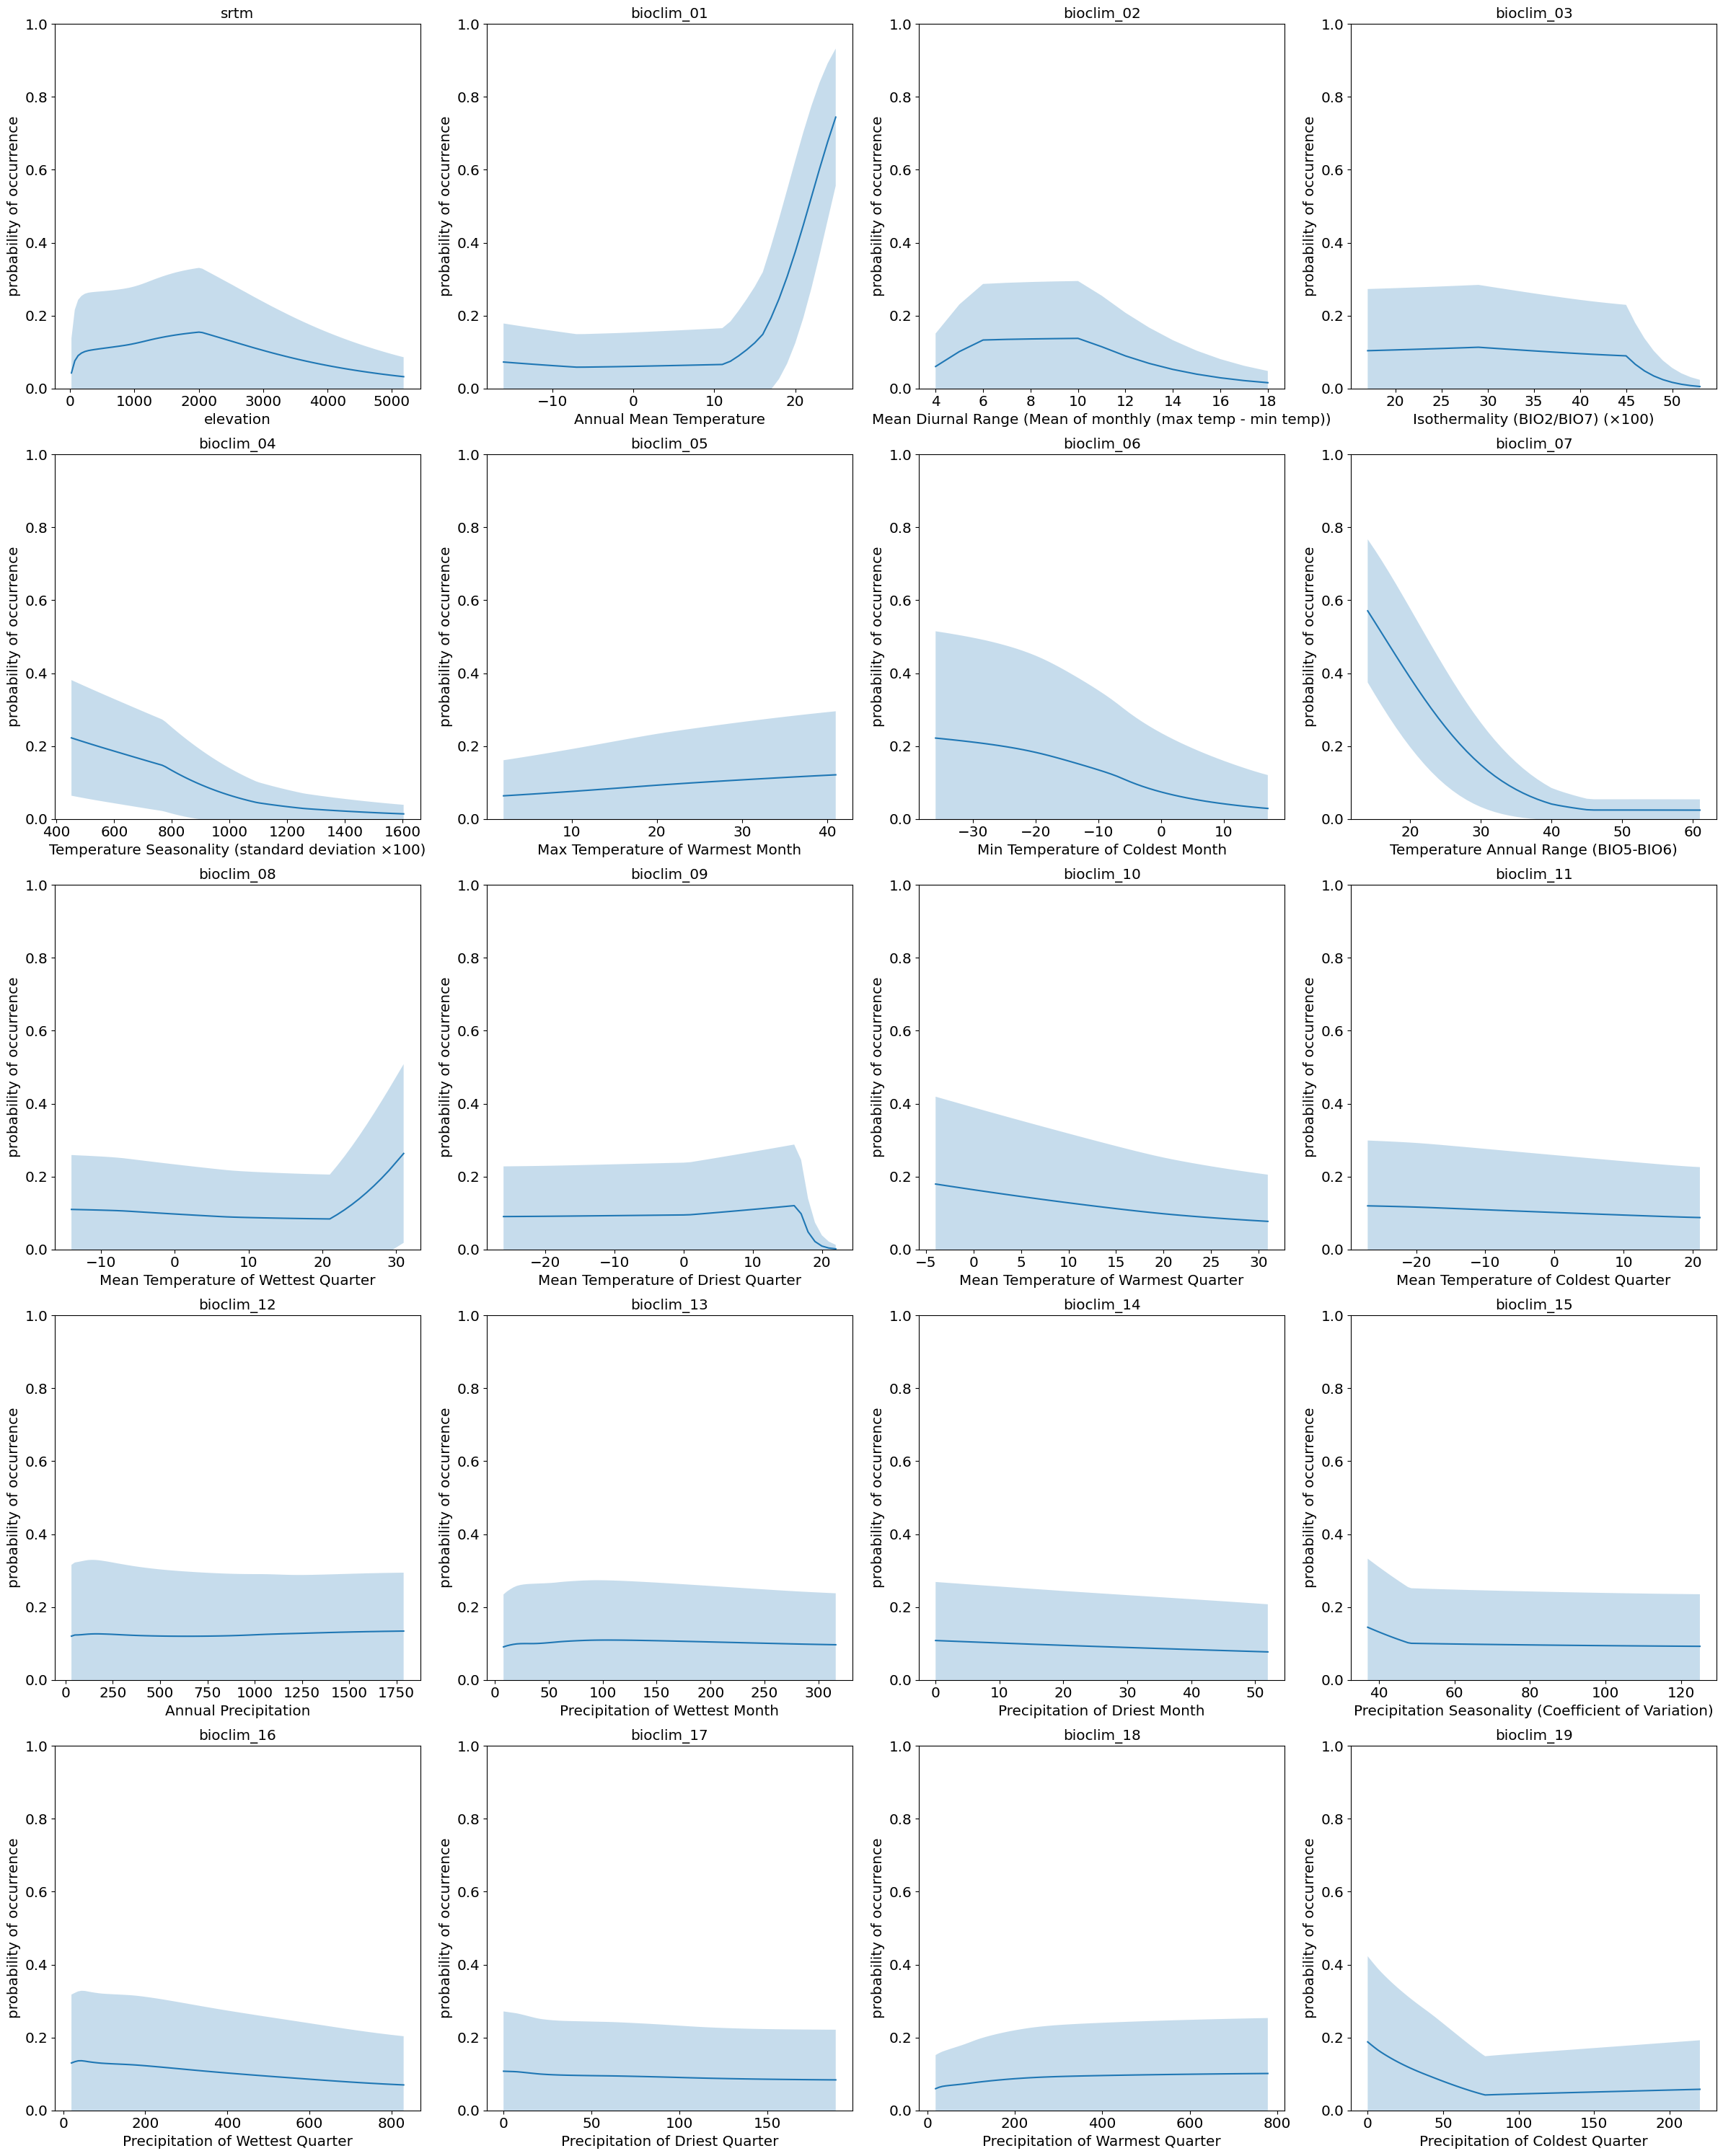

In [20]:
ncols, nrows = subplot_layout(len(labels))

fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*6,nrows*6))

if (nrows, ncols) == (1, 1):
    ax = [axs]
else:
    ax = axs.ravel()

xlabels = training_output.data_vars
for iax, label in enumerate(labels):

    ax[iax].set_title(label)
    try:
        ax[iax].set_xlabel(xlabels[label].long_name)
    except (ValueError, AttributeError):
        ax[iax].set_xlabel('No variable long_name')

    ax[iax].fill_between(bins[label], mean[label] - stdv[label], mean[label] + stdv[label], alpha=0.25)
    ax[iax].plot(bins[label], mean[label])
    ax[iax].set_title(label)

    
# turn off empty plots
for axi in ax:
    axi.set_ylim([0, 1])
    axi.set_ylabel('probability of occurrence')
#     if not axi.lines:
#         axi.set_visible(False)

fig.tight_layout()

In [21]:
if savefig:
    fig.savefig(os.path.join(figs_path, '06_resp-curves_%s_%s.png' %(specie, training)), transparent=True, bbox_inches='tight')

### 3.3 Variable importance plot

In [22]:
# fig, ax = model_train.permutation_importance_plot(x,y)

In [23]:
pi = inspection.permutation_importance(model_train, x_train, y_train, n_repeats=10)
importance = pi.importances
rank_order = importance.mean(axis=-1).argsort()

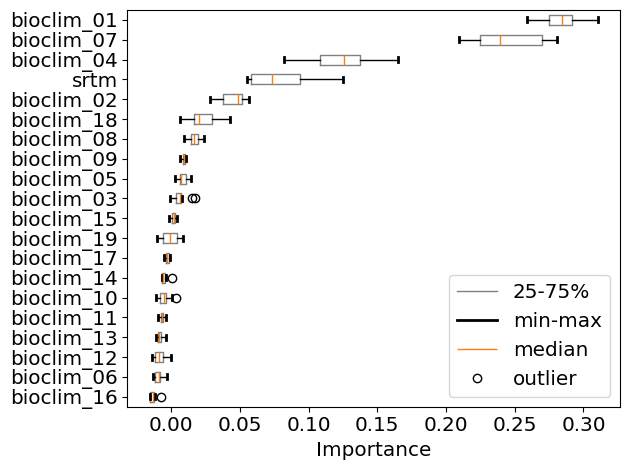

In [24]:
labels_ranked = [labels[idx] for idx in rank_order]

fig, ax = plt.subplots()
box = ax.boxplot(importance[rank_order].T, vert=False, labels=labels_ranked)
box['fliers'][0].set_label('outlier')
box['medians'][0].set_label('median')
for icap, cap in enumerate(box['caps']):
    if icap == 0:
        cap.set_label('min-max')
    cap.set_color('k')
    cap.set_linewidth(2)
for ibx, bx in enumerate(box['boxes']):
    if ibx == 0:
        bx.set_label('25-75%')
    bx.set_color('gray')

ax.set_xlabel('Importance')
ax.legend(loc='lower right')
fig.tight_layout()

In [25]:
if savefig:
    fig.savefig(os.path.join(figs_path, '06_var-importance_%s_%s.png' %(specie, training)), transparent=True, bbox_inches='tight')

TODO (!): variable importance plot for both training and test data